In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
from pytorch_transformers import RobertaTokenizer

In [3]:
#%%bash
#pip install pytorch-pretrained-bert

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

In [5]:
device='cuda'
torch.cuda.set_device(2)

In [6]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("") 

train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["task2_trainset.csv", "task2_public_testset.csv"]]

In [7]:
train.drop('Title',axis=1,inplace=True)
train.drop('Categories',axis=1,inplace=True)
test.drop('Title',axis=1,inplace=True)
test.drop('Categories',axis=1,inplace=True)
####################################################
train.drop('Created Date',axis=1, inplace=True)
train.drop('Authors',axis=1,inplace=True)
test.drop('Created Date',axis=1, inplace=True)
test.drop('Authors',axis=1,inplace=True)

In [8]:
train['THEORETICAL']=0
train['ENGINEERING']=0
train['EMPIRICAL']=0
train['OTHERS']=0
for i in range(train.Id.count()):
    string = train['Task 2'][i]
    train['THEORETICAL'][i] = 1 if (string.find('THEORETICAL')!=-1) else 0
    train['ENGINEERING'][i] = 1 if (string.find('ENGINEERING')!=-1) else 0
    train['EMPIRICAL'][i] = 1 if (string.find('EMPIRICAL')!=-1) else 0
    train['OTHERS'][i] = 1 if (string.find('OTHERS')!=-1) else 0   
train.head()

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/IPL915/.co

,Id,Abstract,Task 2,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL,1,0,0,0
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL,1,0,0,0
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING,0,1,0,0
3,D00004,Internet is the main source of information now...,EMPIRICAL,0,0,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING,0,1,0,0


In [9]:
train.drop('Task 2',axis=1,inplace=True)
train

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,1,0,0,0
1,D00002,"In this paper, we address the problem of compu...",1,0,0,0
2,D00003,High quality upsampling of sparse 3D point clo...,0,1,0,0
3,D00004,Internet is the main source of information now...,0,0,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,0,1,0,0
...,...,...,...,...,...,...
6995,D06996,We have witnessed the discovery of many techni...,1,1,0,0
6996,D06997,State-of-the-art slot filling models for goal-...,0,1,0,0
6997,D06998,Real-time semantic segmentation plays an impor...,0,1,0,0
6998,D06999,We propose a neural embedding algorithm called...,1,0,1,0


In [10]:
for i in range(train.Id.count()):
    train['Abstract'][i]=train['Abstract'][i].replace("$$$", " ")
    train['Abstract'][i]=train['Abstract'][i].replace(".", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("->", "to")
    train['Abstract'][i]=train['Abstract'][i].replace("~", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("&", "and")
    train['Abstract'][i]=train['Abstract'][i].replace(",", " ")
    train['Abstract'][i]=train['Abstract'][i].replace(":", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("%", "percentage")
    train['Abstract'][i]=train['Abstract'][i].replace("C++", "c plus plus")
    train['Abstract'][i]=train['Abstract'][i].replace("w.r.t.", "in respect of")
    train['Abstract'][i]=train['Abstract'][i].replace("e.g.", "example")
    train['Abstract'][i]=train['Abstract'][i].replace("etc.", "and so on")
    #train['Abstract'][i]=train['Abstract'][i].replace("'s'", "s")
    #train['Abstract'][i]=train['Abstract'][i].replace("%", "in other word")
    train['Abstract'][i]=train['Abstract'][i].replace("(A)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(B)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(C)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(D)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(a)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(b)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(c)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(d)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(e)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(1)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(2)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(3)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(4)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(5)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(i)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(ii)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(iii)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(iv)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("i)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("ii)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("iii)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("iv)", " ")
    train['Abstract'][i]=train['Abstract'][i].replace("(", " ")
    train['Abstract'][i]=train['Abstract'][i].replace(")", " ")

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [11]:
for i in range(test.Id.count()):
    test['Abstract'][i]=test['Abstract'][i].replace("$$$", " ")
    test['Abstract'][i]=test['Abstract'][i].replace(".", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("->", "to")
    test['Abstract'][i]=test['Abstract'][i].replace("~", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("&", "and")
    test['Abstract'][i]=test['Abstract'][i].replace(",", " ")
    test['Abstract'][i]=test['Abstract'][i].replace(":", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("%", "percentage")
    test['Abstract'][i]=test['Abstract'][i].replace("C++", "c plus plus")
    test['Abstract'][i]=test['Abstract'][i].replace("w.r.t.", "in respect of")
    test['Abstract'][i]=test['Abstract'][i].replace("e.g.", "example")
    test['Abstract'][i]=test['Abstract'][i].replace("etc.", "and so on")
    #test['Abstract'][i]=test['Abstract'][i].replace("'s'", "s")
    #test['Abstract'][i]=test['Abstract'][i].replace("%", "in other word")
    test['Abstract'][i]=test['Abstract'][i].replace("(A)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(B)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(C)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(D)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(a)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(b)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(c)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(d)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(e)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(1)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(2)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(3)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(4)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(5)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(i)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(ii)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(iii)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(iv)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("i)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("ii)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("iii)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("iv)", " ")
    test['Abstract'][i]=test['Abstract'][i].replace("(", " ")
    test['Abstract'][i]=test['Abstract'][i].replace(")", " ")

In [12]:
train, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=SEED)

In [13]:
train.head()

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
1032,D01033,Many computer vision applications such as obj...,1,1,0,0
6339,D06340,Many experimental proposals for noisy intermed...,1,0,0,0
3886,D03887,In the present paper we describe the technolog...,0,1,0,0
2653,D02654,An important property of programming language ...,1,0,0,0
6914,D06915,Multilingual topic models enable crosslingual ...,0,1,0,0


In [14]:
train['Abstract'][0]

'Rapid popularity of Internet of Things  IoT  and cloud computing permits neuroscientists to collect multilevel and multichannel brain data to better understand brain functions  diagnose diseases  and devise treatments  To ensure secure and reliable data communication between end-to-end  E2E  devices supported by current IoT and cloud infrastructure  trust management is needed at the IoT and user ends  This paper introduces a Neuro-Fuzzy based Brain-inspired trust management model  TMM  to secure IoT devices and relay nodes  and to ensure data reliability  The proposed TMM utilizes node behavioral trust and data trust estimated using Adaptive Neuro-Fuzzy Inference System and weighted-additive methods respectively to assess the nodes trustworthiness  In contrast to the existing fuzzy based TMMs  the NS2 simulation results confirm the robustness and accuracy of the proposed TMM in identifying malicious nodes in the communication network  With the growing usage of cloud based IoT framewor

In [15]:
val.head()

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
6500,D06501,In this paper we present the Creative Inventio...,0,0,0,1
2944,D02945,Computer algorithms are written with the inten...,0,1,0,0
2024,D02025,The problem of finding the maximum number of v...,1,0,0,0
263,D00264,Real-world machine learning applications often...,1,0,0,0
4350,D04351,Typically an ontology matching technique is a ...,0,0,1,0


In [16]:
test.head()

,Id,Abstract
0,T00001,Mobile Crowdsensing is a promising paradigm fo...
1,T00002,A keyboard has many function keys and each fun...
2,T00003,With increasing availability of communication ...
3,T00004,The clustered planarity problem c-planarity ...
4,T00005,We introduce a genetic programming method for ...


In [56]:
SEED = 50
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

In [57]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,    
    roberta_model_name='roberta-large', # roberta-basecan also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=4,
    use_fp16=True,
    bs=16, 
    max_seq_len=330, 
    num_labels = 6,
    hidden_dropout_prob=.05,
    hidden_size=1024, # 1024 for roberta-large 768 for base
    start_tok = "<s>",
    end_tok = "</s>",
)

In [58]:
label_cols  = ["THEORETICAL", "ENGINEERING", "EMPIRICAL", "OTHERS"]
feat_cols  = ["Abstract"]


In [59]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [60]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In following code snippets, we need to wrap BERT vocab and BERT tokenizer with Fastai modules

In [61]:
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [62]:
#fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [63]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [64]:
'''
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)
'''

'\n# Creating a Roberta specific DataBunch class\nclass RobertaDataBunch(TextDataBunch):\n    "Create a `TextDataBunch` suitable for training Roberta"\n    @classmethod\n    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr=\'.\', bs:int=64, val_bs:int=None, pad_idx=1,\n               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, \n               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:\n        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"\n        datasets = cls._init_ds(train_ds, valid_ds, test_ds)\n        val_bs = ifnone(val_bs, bs)\n        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)\n        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)\n        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_las

In [65]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_roberta_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [66]:
# this will produce a virtually identical databunch to the code above
data = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_roberta_vocab,
                  text_cols=feat_cols,
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [67]:
'''
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList
'''

'\nclass RobertaTextList(TextList):\n    _bunch = RobertaDataBunch\n    _label_cls = TextList\n'

In this project, we will be using Databunch which is easier to create and use.

In [68]:
'''
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)


# creating our databunch 
data = RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)
'''


'\n# loading the tokenizer and vocab processors\nprocessor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)\n\n\n# creating our databunch \ndata = RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor)     .split_by_rand_pct(seed=config.seed)     .label_from_df(cols=label_cols,label_cls=CategoryList)     .databunch(bs=config.bs, pad_first=False, pad_idx=0)\n'

In [69]:
data.show_batch()

text,target
<s> ĠSy bil Ġdetection Ġin Ġsocial Ġnetworks Ġis Ġa Ġbasic Ġsecurity Ġresearch Ġproblem Ġ ĠStructure - based Ġmethods Ġhave Ġbeen Ġshown Ġto Ġbe Ġpromising Ġat Ġdetecting ĠSy b ils Ġ ĠEx isting Ġstructure - based Ġmethods Ġcan Ġbe Ġclassified Ġinto ĠRandom ĠWalk Ġ ĠRW Ġ- based Ġmethods Ġand ĠLoop ĠBelief ĠProp ag ation Ġ ĠL BP Ġ- based Ġmethods Ġ ĠRW - based Ġmethods Ġcannot Ġleverage Ġlabeled ĠSy b ils,THEORETICAL
"<s> ĠLamb da Ġcalculus Ġis Ġthe Ġbasis Ġof Ġfunctional Ġprogramming Ġand Ġhigher Ġorder Ġproof Ġassistants Ġ ĠHowever Ġ Ġlittle Ġis Ġknown Ġabout Ġcomb inator ial Ġproperties Ġof Ġlambda Ġterms Ġ Ġin Ġparticular Ġ Ġabout Ġtheir Ġas ym pt otic Ġdistribution Ġand Ġrandom Ġgeneration Ġ ĠThis Ġpaper Ġtries Ġto Ġanswer Ġquestions Ġlike Ġ ĠHow Ġmany Ġterms Ġof Ġa Ġgiven Ġsize Ġare Ġthere ? ĠWhat Ġis Ġa Ġ"" typ ical "" Ġstructure",THEORETICAL
<s> ĠRecent Ġyears Ġhave Ġseen Ġthe Ġincreasing Ġneed Ġof Ġlocation Ġawareness Ġby Ġmobile Ġapplications Ġ ĠThis Ġpaper Ġpresents Ġa Ġroom - level Ġindoor Ġlocalization Ġapproach Ġbased Ġon Ġthe Ġmeasured Ġroom 's Ġe ch os Ġin Ġresponse Ġto Ġa Ġtwo - mill isec ond Ġsingle - tone Ġin aud ible Ġch ir p Ġemitted Ġby Ġa Ġsmartphone 's Ġloudspe aker Ġ ĠDifferent Ġfrom Ġother Ġac oust ics - based Ġroom Ġrecognition,ENGINEERING
<s> ĠOne Ġviable Ġsolution Ġfor Ġcontinuous Ġreduction Ġin Ġenergy - per - operation Ġis Ġto Ġrethink Ġfunctionality Ġto Ġcope Ġwith Ġuncertainty Ġby Ġadopting Ġcomputational Ġapproaches Ġthat Ġare Ġinherently Ġrobust Ġto Ġuncertainty Ġ ĠIt Ġrequires Ġa Ġnovel Ġlook Ġat Ġdata Ġrepresentations Ġ Ġassociated Ġoperations Ġ Ġand Ġcircuits Ġ Ġand Ġat Ġmaterials Ġand Ġsubstr ates Ġthat Ġenable Ġthem Ġ Ġ3 D Ġintegrated Ġnan ote chn ologies Ġcombined Ġwith Ġnovel Ġbrain - inspired,ENGINEERING
<s> ĠNumerous Ġvariants Ġof ĠSelf - Organ izing ĠMaps Ġ ĠSOM s Ġ Ġhave Ġbeen Ġproposed Ġin Ġthe Ġliterature Ġ Ġincluding Ġthose Ġwhich Ġalso Ġpossess Ġan Ġunderlying Ġstructure Ġ Ġand Ġin Ġsome Ġcases Ġ Ġthis Ġstructure Ġitself Ġcan Ġbe Ġdefined Ġby Ġthe Ġuser ĠAlthough Ġthe Ġconcepts Ġof Ġgrowing Ġthe ĠSOM Ġand Ġupdating Ġit Ġhave Ġbeen Ġstudied Ġ Ġthe Ġwhole Ġissue Ġof Ġusing Ġa Ġself - organ izing ĠAdapt ive ĠData,THEORETICAL


# Model

In [70]:
import torch.nn as nn
from pytorch_transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=4):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [71]:
roberta_model = CustomRobertaModel()

learn = Learner(data,roberta_model,metrics=[fbeta],callback_fns=ShowGraph)

In [72]:
if config.use_fp16: learn=learn.to_fp16()

epoch,train_loss,valid_loss,fbeta,time
0,0.455207,0.417660,0.776905,02:02
1,0.410774,0.391713,0.802395,02:01
2,0.351553,0.386920,0.798695,02:02
3,0.326071,0.393323,0.798942,02:02


A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

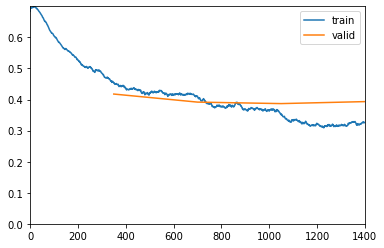

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

In [73]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(4, max_lr=config.max_lr)

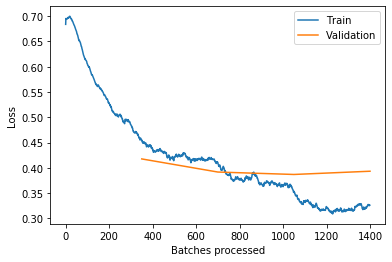

In [74]:
learn.recorder.plot_losses()

In [36]:
'''
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]
'''


'\ndef get_preds_as_nparray(ds_type) -> np.ndarray:\n    """\n    the get_preds method does not yield the elements in order by default\n    we borrow the code from the RNNLearner to resort the elements into their correct order\n    """\n    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()\n    sampler = [i for i in databunch.dl(ds_type).sampler]\n    reverse_sampler = np.argsort(sampler)\n    return preds[reverse_sampler, :]\n'

In [37]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [38]:
#test_preds = get_preds_as_nparray(DatasetType.Test)
test_preds, test_preds_values = get_preds_as_nparray(DatasetType.Test)

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your encoding.
A sequence with no special tokens has been passed to the RoBERTa model. This model require

In [39]:
test_preds_values

array([0, 1, 1, 0, ..., 1, 0, 1, 0])

In [40]:
threshold_preds = (test_preds>=0.5).astype(int)
threshold_preds

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [41]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [42]:
SubmitGenerator(threshold_preds, 
                'task2_sample_submission.csv',
                True, 
                'task2_submission.csv')

In [95]:
import time
torch.cuda.empty_cache() 
time.sleep(100)